<a href="https://colab.research.google.com/github/linhlinhle997/neural-translation-en-vi/blob/develop/nt_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import os
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

import sacrebleu
import torch
import torch.nn as nn
from tokenizers import Tokenizer, pre_tokenizers, trainers, models
from transformers import (
    PreTrainedTokenizerFast,
    PreTrainedModel,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    AutoTokenizer
)

In [ ]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.parallel")
os.environ["PYTHONWARNINGS"] = "ignore"

## Data Preprocessing

In [ ]:
ds = load_dataset("thainq107/iwslt2015-en-vi")

README.md:   0%|          | 0.00/522 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/133317 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1268 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1268 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['en', 'vi'],
        num_rows: 133317
    })
    validation: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
    test: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
})

In [ ]:
ds['train'][0]

{'en': 'Rachel Pike : The science behind a climate headline',
 'vi': 'Khoa học đằng sau một tiêu đề về khí hậu'}

Word-Based

In [ ]:
tokenizer_en = Tokenizer(models.WordLevel(unk_token="<unk>"))
tokenizer_vi = Tokenizer(models.WordLevel(unk_token="<unk>"))

tokenizer_en.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer_vi.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.WordLevelTrainer(
    vocab_size=15000,
    min_frequency=2,
    special_tokens=["<pad>", "<unk>", "<bos>", "<eos>"]
)

Trains Tokenizer

In [ ]:
tokenizer_en.train_from_iterator(ds["train"]["en"], trainer)
tokenizer_vi.train_from_iterator(ds["train"]["vi"], trainer)

Tokenizer

In [ ]:
tokenizer_en.save("tokenizer_en.json")
tokenizer_vi.save("tokenizer_vi.json")

In [ ]:
len(tokenizer_en.get_vocab()), len(tokenizer_vi.get_vocab())

(15000, 13684)

In [ ]:
print(tokenizer_en.encode("how are you"))

Encoding(num_tokens=3, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [ ]:
print(tokenizer_en.encode("how are you").ids)
print(tokenizer_vi.encode("bạn có khoẻ không").ids)

[81, 27, 18]
[18, 9, 596, 14]


## Encoding

In [ ]:
tokenizer_en = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer_en.json",
    unk_token="<unk>",
    pad_token="<pad>",
    bos_token="<bos>",
    eos_token="<eos>"
)
tokenizer_vi = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer_vi.json",
    unk_token="<unk>",
    pad_token="<pad>",
    bos_token="<bos>",
    eos_token="<eos>"
)

In [ ]:
len(tokenizer_en), len(tokenizer_vi)

(15000, 13684)

In [ ]:
MAX_LEN = 75

def preprocess_func(examples):
    src_texts = examples["en"]
    tgt_texts = ["<bos> " + sent + "<eos>" for sent in examples["vi"]]

    src_encodings = tokenizer_en(
        src_texts, padding="max_length", truncation=True, max_length=MAX_LEN
    )
    tgt_encodings = tokenizer_vi(
        tgt_texts, padding="max_length", truncation=True, max_length=MAX_LEN
    )

    return {
        "input_ids": src_encodings["input_ids"],
        "labels": tgt_encodings["input_ids"],
    }

preprocessed_ds = ds.map(preprocess_func, batched=True)

Map:   0%|          | 0/133317 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

In [ ]:
tokenizer_vi.unk_token_id, tokenizer_vi.pad_token_id, tokenizer_vi.bos_token_id, tokenizer_vi.eos_token_id

(1, 0, 2, 3)

In [ ]:
preprocessed_ds['train']

Dataset({
    features: ['en', 'vi', 'input_ids', 'labels'],
    num_rows: 133317
})

In [ ]:
print(preprocessed_ds['train'][0])

{'en': 'Rachel Pike : The science behind a climate headline', 'vi': 'Khoa học đằng sau một tiêu đề về khí hậu', 'input_ids': [6675, 1, 57, 60, 339, 604, 13, 744, 5643, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [2, 1960, 66, 1157, 131, 8, 376, 113, 38, 417, 735, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


## Transformer Model

In [ ]:
def generate_square_subsequent_mask(sz, device):
    # Create an upper triangular mask to prevent the model from seeing future tokens.
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)  # Upper triangular matrix
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)) # Apply mask values
    return mask


def create_mask(src, tgt):
    # Generate masks for source and target sequences to handle attention.
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]
    device = src.device

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device).to(torch.bool) # Prevents future token access
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool) # Required by PyTorch
    src_padding_mask = (src == 0) # Padding masks (PAD = 0)
    tgt_padding_mask = (tgt == 0) # Padding masks (PAD = 0)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
class Seq2SeqTransformerConfig(PretrainedConfig):
    def __init__(
        self,
        vocab_size_src=10000,
        vocab_size_tgt=10000,
        max_seq_length=50,
        d_model=256,
        num_heads=8,
        num_layers=2,
        dropout=0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size_src = vocab_size_src
        self.vocab_size_tgt = vocab_size_tgt
        self.max_seq_length = max_seq_length
        self.d_model = d_model # Hidden layer dimension
        self.num_heads = num_heads # Number of attention heads
        self.num_layers = num_layers # Number of encoder & decoder layers
        self.dropout = dropout


class Seq2SeqTransformerModel(PreTrainedModel):
    config_class = Seq2SeqTransformerConfig

    def __init__(self, config):
        super().__init__(config)

        # Embeddings for source & target
        self.embedding_src = nn.Embedding(config.vocab_size_src, config.d_model)
        self.embedding_tgt = nn.Embedding(config.vocab_size_tgt, config.d_model)

        # Positional embeddings for source & target
        self.position_embedding_src = nn.Embedding(config.max_seq_length, config.d_model)
        self.position_embedding_tgt = nn.Embedding(config.max_seq_length, config.d_model)

        # Transformer model
        self.transformer = nn.Transformer(
            d_model=config.d_model,
            nhead=config.num_heads,
            num_encoder_layers=config.num_layers,
            num_decoder_layers=config.num_layers,
            dropout=config.dropout,
            batch_first=True
        )

        # Output layer & loss function
        self.generator = nn.Linear(config.d_model, config.vocab_size_tgt)
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Ignore PAD token

    def forward(self, input_ids, labels):
        tgt_input = labels[:, :-1] # Shift target for teacher forcing
        tgt_output = labels[:, 1:]

        batch_size, seq_len_src = input_ids.shape
        _, seq_len_tgt = tgt_input.shape

        # Positional encoding
        src_positions = torch.arange(seq_len_src, device=input_ids.device).unsqueeze(0)
        tgt_positions = torch.arange(seq_len_tgt, device=labels.device).unsqueeze(0)

        # Embedded inputs
        src_embedded = self.embedding_src(input_ids) + self.position_embedding_src(src_positions)
        tgt_embedded = self.embedding_tgt(tgt_input) + self.position_embedding_tgt(tgt_positions)

        # Create masks
        src_mask, tgt_mask, src_key_padding_mask, tgt_key_padding_mask = create_mask(input_ids, tgt_input)

        # Transformer forward pass
        outs = self.transformer(
            src_embedded, tgt_embedded, src_mask, tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        # Compute loss
        logits = self.generator(outs)
        loss = self.loss_fn(logits.permute(0, 2, 1), tgt_output)

        return {"loss": loss, "logits": logits}

    def encode(self, src, src_mask):
        # Encode source sequence
        _, seq_len_src = src.shape
        src_positions = torch.arange(seq_len_src, device=src.device).unsqueeze(0)
        src_embedded = self.embedding_src(src) + self.position_embedding_src(src_positions)
        return self.transformer.encoder(src_embedded, src_mask)

    def decode(self, tgt, encoder_output, tgt_mask):
         Decode target sequence
        _, seq_len_tgt = tgt.shape
        tgt_positions = torch.arange(seq_len_tgt, device=tgt.device).unsqueeze(0)
        tgt_embedded = self.embedding_tgt(tgt) + self.position_embedding_tgt(tgt_positions)
        return self.transformer.decoder(tgt_embedded, encoder_output, tgt_mask)

In [ ]:
config = Seq2SeqTransformerConfig(
    vocab_size_src=len(tokenizer_en),
    vocab_size_tgt=len(tokenizer_vi),
    max_seq_length=75
)
model = Seq2SeqTransformerModel(config)

In [ ]:
model

Seq2SeqTransformerModel(
  (embedding_src): Embedding(15000, 256)
  (embedding_tgt): Embedding(13684, 256)
  (position_embedding_src): Embedding(75, 256)
  (position_embedding_tgt): Embedding(75, 256)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=

Test model

In [ ]:
input_ids = torch.tensor([preprocessed_ds['train'][0]['input_ids']])
labels = torch.tensor([preprocessed_ds['train'][0]['labels']])

In [ ]:
input_ids

tensor([[6675,    1,   57,   60,  339,  604,   13,  744, 5643,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]])

In [ ]:
labels

tensor([[   2, 1960,   66, 1157,  131,    8,  376,  113,   38,  417,  735,    3,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0]])

In [ ]:
pred = model(input_ids, labels)
pred

{'loss': tensor(9.6530, grad_fn=<NllLoss2DBackward0>),
 'logits': tensor([[[ 0.3495, -0.2818,  0.1786,  ..., -0.7058,  0.1305, -1.2205],
          [-0.2961, -0.5281, -0.0144,  ...,  0.3663,  0.1412,  0.5039],
          [-0.0143, -0.5832,  0.6912,  ...,  0.6935, -0.9150,  0.0257],
          ...,
          [-0.4990, -0.6688,  1.0047,  ...,  0.5314, -0.8367, -0.4483],
          [-0.3394, -0.1699,  0.8653,  ...,  0.4656, -0.0164, -0.2122],
          [ 0.0267, -0.6954,  0.9298,  ...,  0.1758, -0.2867,  0.1819]]],
        grad_fn=<ViewBackward0>)}

## Training

In [ ]:
training_args = TrainingArguments(
    output_dir="./en-vi-mt",
    logging_dir="logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",  # Log by steps instead of epoch
    logging_steps=10,  # Log loss every 10 steps
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=15,
    learning_rate=2e-5,
    save_total_limit=1,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_ds["train"],
    eval_dataset=preprocessed_ds["validation"]
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,5.489500,5.451352
2,5.038000,5.009047
3,4.706100,4.754123
4,4.615200,4.583409
5,4.480100,4.463354
6,4.337700,4.371575
7,4.311300,4.295552
8,4.257000,4.238587
9,4.160400,4.188950
10,4.164600,4.152390


TrainOutput(global_step=31260, training_loss=4.502006862930815, metrics={'train_runtime': 3667.9406, 'train_samples_per_second': 545.198, 'train_steps_per_second': 8.522, 'total_flos': 8373888073035000.0, 'train_loss': 4.502006862930815, 'epoch': 15.0})

Display charts

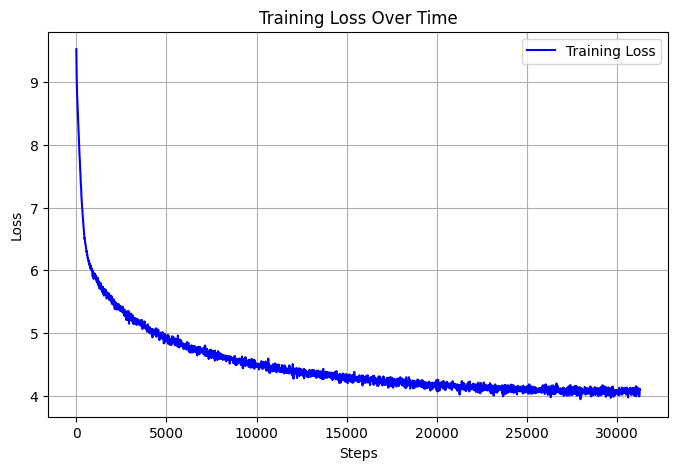

In [ ]:
train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
steps = [log["step"] for log in trainer.state.log_history if "loss" in log]

plt.figure(figsize=(8, 5))
plt.plot(steps, train_losses, label="Training Loss", color="blue")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid()
plt.show()

## Inference

Greedy search

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, device="cpu"):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask) # Encode input sequence
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device) # Init target sequence

    # Loop to generate tokens
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1), device).type(torch.bool)).to(device) # Create target mask

        out = model.decode(ys, memory, tgt_mask) # Decode using current target sequence
        prob = model.generator(out[:, -1, :]) # Get probabilities of next token
        _, next_word = torch.max(prob, dim=1) # Select most probable word
        next_word = next_word[-1].item() # Convert to int

        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == 3: # Stop if EOS tokene)
            break
    return ys


def translate_greddy(model, src_sentence, device):
    model.eval()
    input_ids = tokenizer_en([src_sentence], return_tensors='pt')['input_ids'].to(device)
    num_tokens = input_ids.shape[1]

    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(device) #  Create mask

    tgt_tokens = greedy_decode(
        model,  input_ids, src_mask, max_len=num_tokens + 5, start_symbol=2, device=device
    ) # Decode
    return tokenizer_vi.decode(tgt_tokens.detach().cpu()[0])  # Convert tokens to text

In [ ]:
translation = translate_greddy(model, "I go to school", model.device)
print(translation)

Beam search

In [ ]:
def beam_decode(model, src, src_mask, max_len, start_symbol, beam_size, device="cpu"):
    model.eval()

    memory = model.encode(src, src_mask) # Encode input
    seq = torch.tensor([[start_symbol]], dtype=torch.long, device=device)  # Start sequence

    for _ in range(max_len - 1):  # Generate tokens
        num_tokens = seq.shape[1]  # Get the current sequence length

        tgt_mask = torch.triu(torch.ones(num_tokens, num_tokens), diagonal=1).bool().to(device) # Create causal mask

        out = model.decode(seq, memory, tgt_mask)  # Decode
        out = out[:, -1, :] #  Get last token logits
        probs = F.log_softmax(out, dim=-1)  # Compute log probabilities

        next_token = torch.argmax(probs, dim=-1).unsqueeze(0) # Pick highest probability token
        seq = torch.cat([seq, next_token], dim=1)

        if next_token.item() == 3:  # Stop if EOS token
            break

    return seq


def translate_beam(model, src_sentence, device, beam_size=5):
    input_ids = tokenizer_en.encode(src_sentence, return_tensors="pt").to(device) # Tokenize input
    num_tokens = input_ids.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(device)  # Create mask

    tgt_tokens = beam_decode(
        model, input_ids, src_mask, max_len=num_tokens + 5, start_symbol=2, beam_size=beam_size, device=device
    ) # Decode

    return tokenizer_vi.decode(tgt_tokens.detach().cpu()[0])  # Convert tokens to text

In [ ]:
translation = translate_beam(model, "I go to school", model.device, beam_size=5)
print(translation)

## Evaluate

Greedy search

In [ ]:
pred_sentences, tgt_sentences = [], []
for sample in tqdm(ds['test']):
    src_sentence = sample['en']
    tgt_sentence = sample['vi']

    pred_sentence = translate_greddy(model, src_sentence, device)
    pred_sentences.append(pred_sentence)

    tgt_sentences.append(tgt_sentence)

bleu_score = sacrebleu.corpus_bleu(pred_sentences, [tgt_sentences], force=True)
bleu_score

Beam search

In [ ]:
pred_sentences, tgt_sentences = [], []
for sample in tqdm(ds['test']):
    src_sentence = sample['en']
    tgt_sentence = sample['vi']

    pred_sentence = translate_beam(model, src_sentence, device)
    pred_sentences.append(pred_sentence)

    tgt_sentences.append(tgt_sentence)

bleu_score = sacrebleu.corpus_bleu(pred_sentences, [tgt_sentences], force=True)
bleu_score

In [ ]:
pred_sentences = ['tôi đang đi học']
tgt_sentences = ['tôi đang đi tới trường']
bleu_score = sacrebleu.corpus_bleu(
    pred_sentences, [tgt_sentences], force=True
)
bleu_score